In [1]:
import os
import pickle
import re
import sys
from glob import glob

import climate_envs
import climlab
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import tqdm
import xarray as xr

In [2]:
BASE_DIR = "/gws/nopw/j04/ai4er/users/pn341/climate-rl"
RECORDS_DIR = f"{BASE_DIR}/records"
DATASETS_DIR = f"{BASE_DIR}/datasets"
IMGS_DIR = f"{BASE_DIR}/results/imgs/"
NUM_STEPS = 500

sys.path.append(BASE_DIR)

In [3]:
fp = f"{DATASETS_DIR}/air.mon.ltm.1981-2010.nc"

if not os.path.exists(fp):
    print("Downloading NCEP air data ...")
    ncep_url = (
        "https://downloads.psl.noaa.gov/Datasets/ncep.reanalysis/Monthlies/"
    )
    ncep_air = xr.open_dataset(
        ncep_url + "pressure/air.mon.1981-2010.ltm.nc#mode=bytes",
        use_cftime=True,
    )
    ncep_air.to_netcdf(fp)
else:
    print("Loading NCEP air data ...")
    ncep_air = xr.open_dataset(fp, use_cftime=True)

coslat = np.cos(np.deg2rad(ncep_air.lat))
weight = coslat / coslat.mean(dim="lat")
Tobs = (ncep_air.air * weight).mean(dim=("lat", "lon", "time"))

Loading NCEP air data ...


/tmp/ipykernel_1458432/223733448.py:15: DeprecationWarning: Usage of 'use_cftime' as a kwarg is deprecated. Please pass a 'CFDatetimeCoder' instance initialized with 'use_cftime' to the 'decode_times' kwarg instead.
Example usage:
    time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
    ds = xr.open_dataset(decode_times=time_coder)

  ncep_air = xr.open_dataset(fp, use_cftime=True)


In [4]:
rce_state = climlab.column_state(lev=Tobs.level[1:], water_depth=2.5)

h2o = climlab.radiation.ManabeWaterVapor(state=rce_state, lev=Tobs.level[1:])

rad = climlab.radiation.RRTMG(
    name="Radiation (net)",
    state=rce_state,
    specific_humidity=h2o.q,
    S0=1365.0,
    timestep=climlab.constants.seconds_per_day,
    albedo=0.25,
)

conv = climlab.convection.ConvectiveAdjustment(
    name="Convection",
    state=rce_state,
    adj_lapse_rate=6.5,
    timestep=rad.timestep,
)

climlab_rcm = climlab.couple([rad, conv], name="RCE Model")
climlab_rcm.state.Tatm[:] = climlab_rcm.state.Ts


def get_rcm_temp_CtoK(climlab_rcm):
    rcm_temp = np.concatenate(
        [climlab_rcm.Tatm, climlab_rcm.Ts], dtype=np.float32
    )
    rcm_temp -= climlab.constants.tempCtoK
    rcm_temp = xr.DataArray(
        rcm_temp, coords={"level": Tobs.level.values[::-1]}
    )
    return rcm_temp.values


climlab_rcm_temps = [get_rcm_temp_CtoK(climlab_rcm)]
for n in range(NUM_STEPS):
    climlab_rcm.step_forward()
    climlab_rcm_temp = get_rcm_temp_CtoK(climlab_rcm)
    climlab_rcm_temps.append(climlab_rcm_temp)
climlab_rcm_temps = np.array(climlab_rcm_temps)

In [5]:
def extract_algo(dirname):
    match = re.search(r"inference_([a-z0-9]+)_torch", dirname)
    return match.group(1) if match else None


def get_record_fns(exp_id):
    record_fns = glob(f"{RECORDS_DIR}/inf*{exp_id}_*/*/*_{NUM_STEPS}.pth")
    record_fns = [
        fn
        for fn in record_fns
        if extract_algo(os.path.basename(os.path.dirname(fn))) in ALGOS
    ]
    return record_fns

In [6]:
from multiprocessing import Pool, cpu_count


def make_env(env_id):
    def thunk():
        env = gym.make(env_id)
        return env

    return thunk


def recover_states(env_id, seed, actions):
    envs = gym.vector.SyncVectorEnv([make_env(env_id)])
    envs.reset(seed=seed)
    states = []

    for i in range(actions.shape[0]):
        next_obs = envs.step(np.expand_dims(actions[i], 0))[0]
        states.append(next_obs)

    states = np.array(states).squeeze()
    return states


def get_action_row(record_fn):
    with open(record_fn, "rb") as f:
        env_id = record_fn.split("/")[-2].split("__")[0]
        exp_id, algo = record_fn.split("/")[-3:-1]
        exp_id = exp_id.split("_")[1]
        seed = int(algo.split("__")[-2])
        algo = algo.split("__")[1].split("_")[1]

        record_steps = torch.load(f)
        if algo in ["ppo", "trpo"]:  # due to env clipping observations
            rce_RL_state = recover_states(
                env_id, seed, record_steps["actions"]
            )
        else:
            rce_RL_state = record_steps["next_obs"]
        rce_RL_state = np.concatenate((climlab_rcm_temps[0:1], rce_RL_state))

        Tprofile_RL = xr.DataArray(
            rce_RL_state[-1], coords={"level": Tobs.level.values[::-1]}
        )
        error = Tobs.sel(level=[100, 200, 1000]) - Tprofile_RL.sel(
            level=[100, 200, 1000]
        )

        return {
            "exp_id": exp_id,
            "algo": algo,
            "seed": seed,
            "error": error,
            "obs": rce_RL_state,
            "actions": record_steps["actions"],
            "fn": record_fn,
        }


def get_action_rows(record_fns):
    with Pool(processes=cpu_count() - 2) as pool:
        results = list(
            tqdm.tqdm(
                pool.imap_unordered(get_action_row, record_fns),
                total=len(record_fns),
            )
        )
    return [row for row in results if row is not None]

In [7]:
EXPERIMENT_ID = "rce-v0-optim-L-10k"
ALGOS = {"tqc", "ppo", "td3"}

record_fns = get_record_fns(EXPERIMENT_ID)

df = pd.DataFrame(get_action_rows(record_fns))
df["error_mse"] = df["error"].apply(lambda x: np.mean(np.square(x.values)))
df.drop(columns=["error", "obs", "actions"], inplace=True)
df = df.sort_values("error_mse", ascending=True)
df.head(10)

  0%|                                                                | 0/30 [00:00<?, ?it/s]

Loading NCEP air data ...
Loading NCEP air data ...Loading NCEP air data ...

Loading NCEP air data ...
Loading NCEP air data ...
Loading NCEP air data ...
Loading NCEP air data ...
Loading NCEP air data ...Loading NCEP air data ...Loading NCEP air data ...




<frozen importlib._bootstrap>:241: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.
<frozen importlib._bootstrap>:241: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.
<frozen importlib._bootstrap>:241: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation

,exp_id,algo,seed,fn,error_mse
16,rce-v0-optim-L-10k,tqc,3,/gws/nopw/j04/ai4er/users/pn341/climate-rl/rec...,3.353729
7,rce-v0-optim-L-10k,tqc,6,/gws/nopw/j04/ai4er/users/pn341/climate-rl/rec...,3.550987
18,rce-v0-optim-L-10k,tqc,8,/gws/nopw/j04/ai4er/users/pn341/climate-rl/rec...,3.615775
17,rce-v0-optim-L-10k,tqc,9,/gws/nopw/j04/ai4er/users/pn341/climate-rl/rec...,3.822377
19,rce-v0-optim-L-10k,tqc,7,/gws/nopw/j04/ai4er/users/pn341/climate-rl/rec...,3.934954
14,rce-v0-optim-L-10k,tqc,5,/gws/nopw/j04/ai4er/users/pn341/climate-rl/rec...,3.973347
27,rce-v0-optim-L-10k,ppo,4,/gws/nopw/j04/ai4er/users/pn341/climate-rl/rec...,3.987583
26,rce-v0-optim-L-10k,ppo,7,/gws/nopw/j04/ai4er/users/pn341/climate-rl/rec...,3.987583
25,rce-v0-optim-L-10k,ppo,9,/gws/nopw/j04/ai4er/users/pn341/climate-rl/rec...,3.987583
24,rce-v0-optim-L-10k,ppo,8,/gws/nopw/j04/ai4er/users/pn341/climate-rl/rec...,3.987583


In [8]:
from base64 import b64encode

from IPython.display import HTML

video_path = (
    df.values[0][3]
    .replace("/records/", "/videos/")
    .replace(f"step_{NUM_STEPS}.pth", "rl-video-episode-0.mp4")
)
mp4 = open(video_path, "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(
    f"""
<video width=1280 controls>
    <source src="{data_url}" type="video/mp4">
</video>
"""
)

In [9]:
from collections import defaultdict


def get_records(record_fns):
    records = defaultdict(dict)
    for record_fn in record_fns:
        action_row = get_action_row(record_fn)
        algo = action_row["algo"].lower()
        seed = int(action_row["seed"])
        obs = action_row["obs"]
        actions = action_row["actions"]
        records[algo][seed] = {"obs": obs, "actions": actions}
    return records

In [10]:
def plot_RCE_state_action(records, algo, exp_id, pressure_hPa=1000):
    level_arr = np.array(Tobs.level.values)[::-1]
    level_idx = np.abs(level_arr - pressure_hPa).argmin()
    true_pressure = level_arr[level_idx]

    observed_value = float(Tobs.sel(level=true_pressure).mean())

    param_bounds = {
        "emissivity": (0, 1),
        "lapse_rate": (5.5, 9.8),
    }

    def normalise(x, bounds):
        return (x - bounds[0]) / (bounds[1] - bounds[0])

    climlab_state = climlab_rcm_temps[:-2, level_idx]

    obs_list = []
    emissivity_list = []
    lapse_rate_list = []
    for s in records[algo]:
        obs = records[algo][s]["obs"][:-1, level_idx]
        emissivity = records[algo][s]["actions"][:, 0]
        lapse_rate = records[algo][s]["actions"][:, 1]

        obs_list.append(obs)
        emissivity_list.append(
            normalise(emissivity, param_bounds["emissivity"])
        )
        lapse_rate_list.append(
            normalise(lapse_rate, param_bounds["lapse_rate"])
        )

    obs_arr = np.stack(obs_list)
    emissivity_arr = np.stack(emissivity_list)
    lapse_rate_arr = np.stack(lapse_rate_list)

    timesteps = np.arange(len(records[algo][1]["actions"]))

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 4), sharex=True)

    ax1.plot(
        timesteps, obs_arr.mean(axis=0), label="RCE Model w/ RL", color="black"
    )
    ax1.fill_between(
        timesteps,
        obs_arr.mean(axis=0) - obs_arr.std(axis=0),
        obs_arr.mean(axis=0) + obs_arr.std(axis=0),
        color="black",
        alpha=0.2,
    )
    ax1.plot(
        timesteps,
        climlab_state,
        label="RCE Model",
        color="black",
        linestyle="--",
    )
    ax1.axhline(observed_value, label="Observed", color="red", linestyle="--")
    ax1.set_ylabel("Temperature (°C)")
    ax1.set_title(f"{algo.upper()} | {int(true_pressure)} hPa")
    ax1.legend()
    ax1.grid(True)

    ax2.plot(
        timesteps,
        emissivity_arr.mean(axis=0),
        label="Surface Emissivity",
        color="tab:blue",
    )
    ax2.fill_between(
        timesteps,
        emissivity_arr.mean(axis=0) - emissivity_arr.std(axis=0),
        emissivity_arr.mean(axis=0) + emissivity_arr.std(axis=0),
        color="tab:blue",
        alpha=0.3,
    )

    ax2.plot(
        timesteps,
        lapse_rate_arr.mean(axis=0),
        label="Critical Lapse Rate",
        color="tab:orange",
    )
    ax2.fill_between(
        timesteps,
        lapse_rate_arr.mean(axis=0) - lapse_rate_arr.std(axis=0),
        lapse_rate_arr.mean(axis=0) + lapse_rate_arr.std(axis=0),
        color="tab:orange",
        alpha=0.3,
    )

    ax2.set_ylabel("Normalised [0–1]")
    ax2.set_xlabel("Timestep")
    ax2.set_ylim(-0.25, 1.25)
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig(
        f"{IMGS_DIR}/{exp_id}_{algo}_{int(true_pressure)}hPa_TEL.png", dpi=300
    )

Loading NCEP air data ...


<frozen importlib._bootstrap>:241: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.


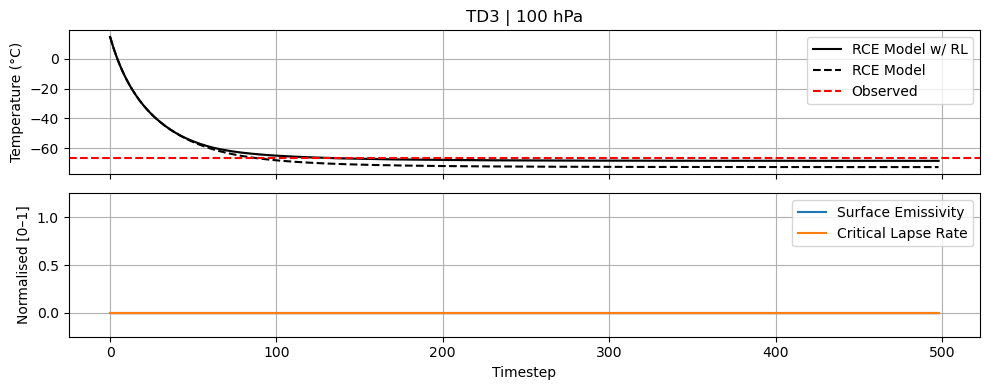

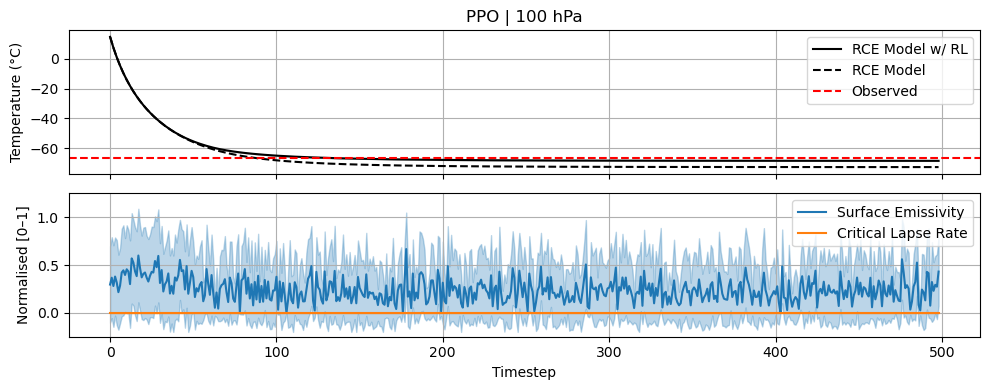

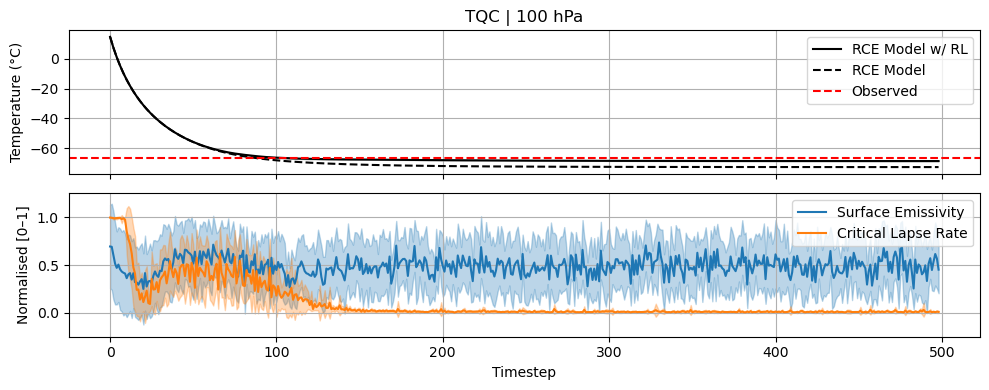

In [11]:
pressure_hPa = 100
records = get_records(record_fns)

for algo in ALGOS:
    plot_RCE_state_action(records, algo, EXPERIMENT_ID, pressure_hPa)

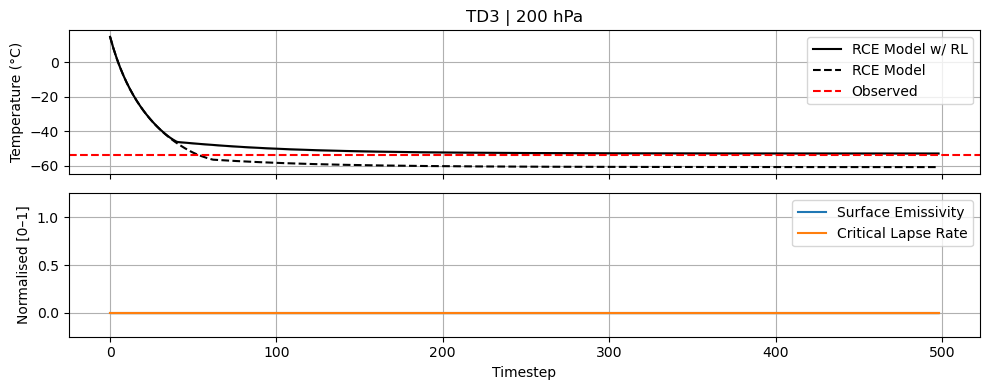

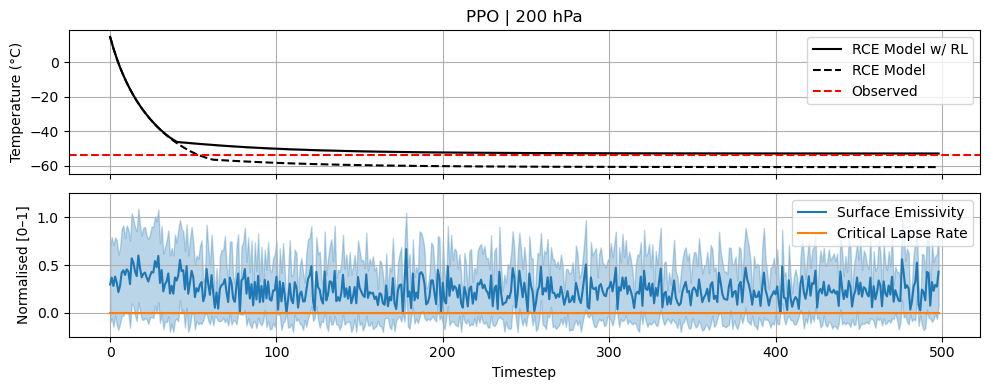

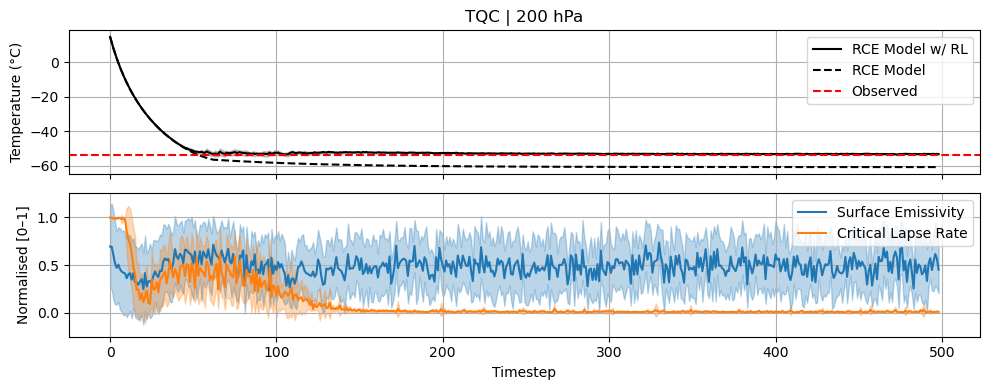

In [12]:
pressure_hPa = 200

for algo in ALGOS:
    plot_RCE_state_action(records, algo, EXPERIMENT_ID, pressure_hPa)

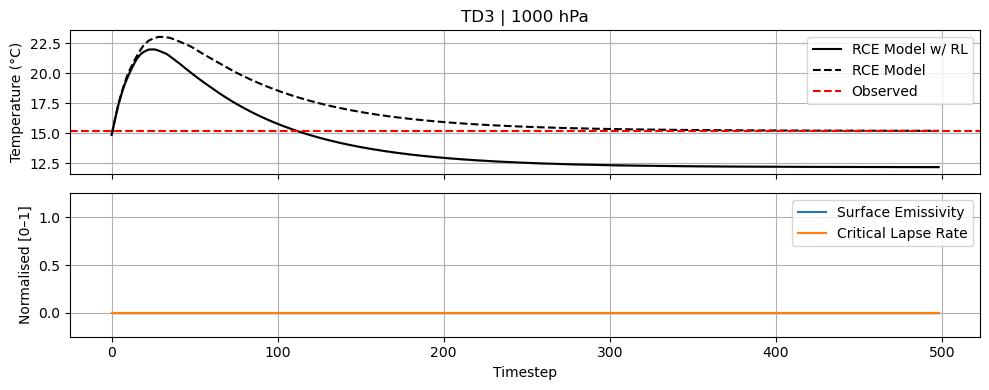

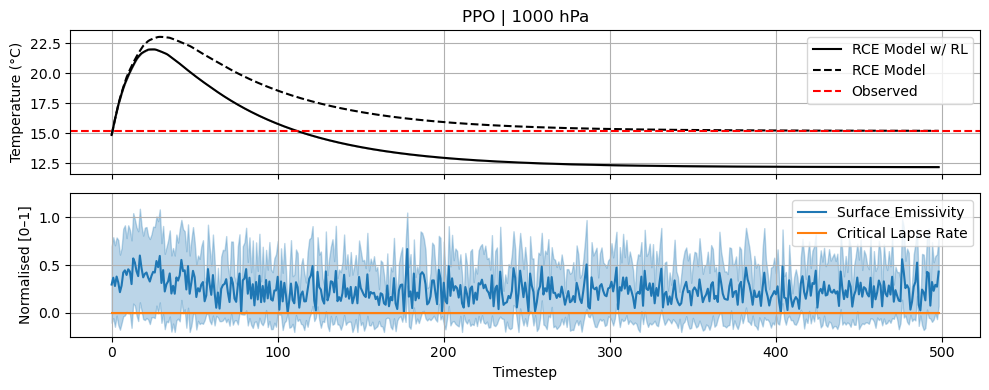

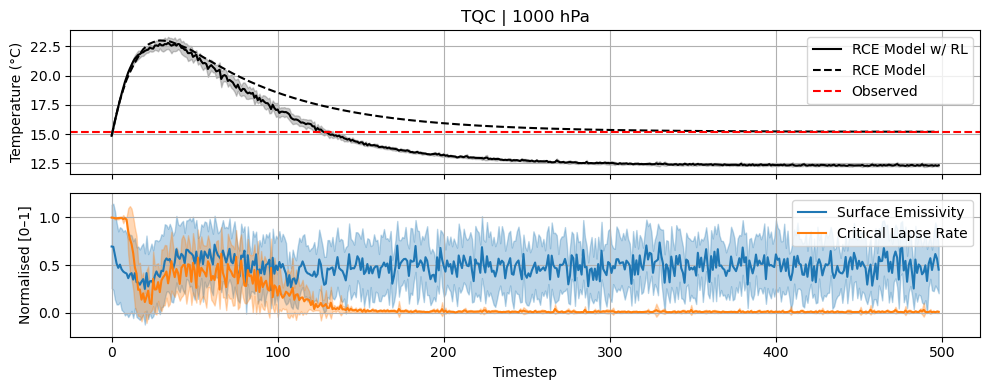

In [13]:
pressure_hPa = 1000

for algo in ALGOS:
    plot_RCE_state_action(records, algo, EXPERIMENT_ID, pressure_hPa)